In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv("football_match_data.csv")
print("Number of matches in dataset:", df.shape[0])


# Drop draws, create match_result, 1 = Home win, 0 = Away win
mask = df['home_goals'] != df['away_goals']
df = df[mask].copy()
df['match_result'] = (df['home_goals'] > df['away_goals']).astype(int)
df.dropna(inplace=True)
print(df.head())

Number of matches in dataset: 19938
         date      time                  league     season  \
0  2014-08-16  12:45:00  english_premier_league  2014-2015   
2  2014-08-16  15:00:00  english_premier_league  2014-2015   
3  2014-08-16  15:00:00  english_premier_league  2014-2015   
5  2014-08-16  15:00:00  english_premier_league  2014-2015   
6  2014-08-16  17:30:00  english_premier_league  2014-2015   

             home_team       away_team  home_goals  away_goals   home_xG  \
0    Manchester United         Swansea         1.0         2.0  1.166350   
2  Queens Park Rangers            Hull         0.0         1.0  1.900670   
3                Stoke     Aston Villa         0.0         1.0  0.423368   
5             West Ham       Tottenham         0.0         1.0  1.853100   
6              Arsenal  Crystal Palace         2.0         1.0  1.554110   

    away_xG  match_result  
0  0.278076             0  
2  1.117570             0  
3  0.909774             0  
5  1.017060           

In [3]:
def add_time_of_day(df):
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['time_of_day'] = df['time'].apply(
        lambda x: 'day' if x < pd.to_datetime('17:00', format='%H:%M').time() else 
        ('evening' if x < pd.to_datetime('19:59', format='%H:%M').time() else 'night')
    )
    return df

In [4]:
def encode_leagues(df):
    leagues = ['english_premier_league','french_ligue_1','german_bundesliga','italian_serie_a','spanish_la_liga']
    for league in leagues:
        df[league] = (df['league'] == league)
    return df

In [5]:
def add_rolling_xG(df):
    df = df.sort_values(by='date')
    df['home_xG_rolling_20'] = df.groupby('home_team')['home_xG'].transform(lambda x: x.shift().rolling(20, min_periods=1).mean())
    df['away_xG_rolling_20'] = df.groupby('away_team')['away_xG'].transform(lambda x: x.shift().rolling(20, min_periods=1).mean())
    return df


In [6]:
df = add_time_of_day(df)
df = encode_leagues(df)
df = add_rolling_xG(df)

In [7]:
df[['date', 'home_team', 'away_team', 'season']].sort_values(by=['date', 'home_team', 'away_team']).duplicated(subset=['date', 'home_team', 'away_team'], keep=False).value_counts()


False    12246
True      2578
Name: count, dtype: int64

In [8]:
df = df.drop_duplicates(subset=['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_xG', 'away_xG'], keep='first')

In [9]:
home_dummies = pd.get_dummies(df['home_team'], prefix='home')
away_dummies = pd.get_dummies(df['away_team'], prefix='away')
df = pd.concat([df, home_dummies, away_dummies], axis=1)


In [10]:
df.drop(columns=['date', 'time', 'league', 'season', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_xG', 'away_xG'], inplace=True)

In [11]:
df.replace({True: 1, False: 0}, inplace=True)
df = pd.concat([df, pd.get_dummies(df['time_of_day'], prefix='time')], axis=1)
df.drop(columns=['time_of_day'], inplace=True)
df.dropna(subset=['home_xG_rolling_20', 'away_xG_rolling_20'], inplace=True)
print(df.head())

C:\Users\99jon\AppData\Local\Temp\ipykernel_19820\19011937.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


      match_result  english_premier_league  french_ligue_1  german_bundesliga  \
1469             0                       0               1                  0   
1473             0                       0               1                  0   
1475             0                       0               1                  0   
1479             1                       0               1                  0   
1478             1                       0               1                  0   

      italian_serie_a  spanish_la_liga  home_xG_rolling_20  \
1469                0                0            2.214810   
1473                0                0            2.064000   
1475                0                0            1.025000   
1479                0                0            1.439560   
1478                0                0            1.806705   

      away_xG_rolling_20  home_AC Milan  home_Ajaccio  ...  away_Villarreal  \
1469            0.750184              0             0  ...   

In [12]:
team_name = "Liverpool" 

# Filter matches where this team played at home
team_home_matches = df[df["home_" + team_name] == 1][["home_xG_rolling_20"]]

# Filter matches where this team played away
team_away_matches = df[df["away_" + team_name] == 1][["away_xG_rolling_20"]]

# Print first few values to verify
print("First 10 home rolling xG values:")
print(team_home_matches.head(10))

print("\nFirst 10 away rolling xG values:")
print(team_away_matches.head(10))


First 10 home rolling xG values:
     home_xG_rolling_20
37             1.331920
62             1.030009
100            1.207216
123            1.038388
189            1.172760
221            1.523397
243            1.631773
266            1.773357
277            1.661764
296            1.626040

First 10 away rolling xG values:
     away_xG_rolling_20
28             0.901889
45             1.822530
77             1.341136
90             1.385385
117            1.160098
131            1.125575
157            1.150664
171            1.240724
200            1.221430
210            1.315538


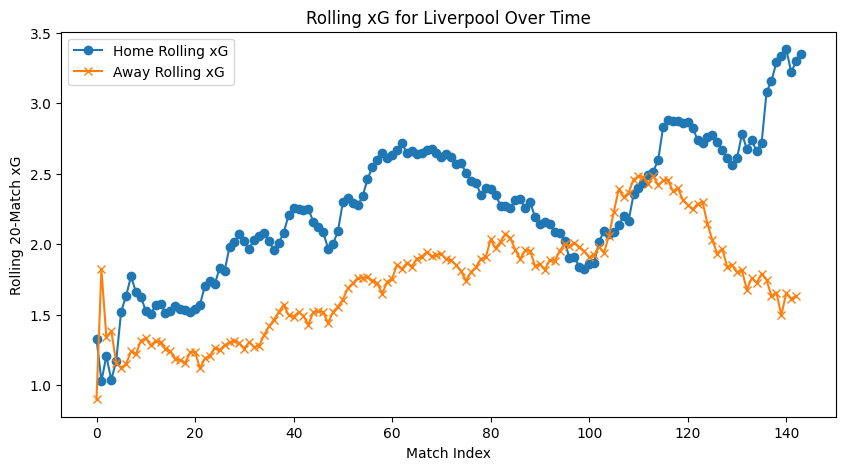

In [13]:
# Plot home and away rolling xG over match index
plt.figure(figsize=(10,5))
plt.plot(team_home_matches.reset_index(drop=True), label="Home Rolling xG", marker="o")
plt.plot(team_away_matches.reset_index(drop=True), label="Away Rolling xG", marker="x")
plt.xlabel("Match Index")
plt.ylabel("Rolling 20-Match xG")
plt.title(f"Rolling xG for {team_name} Over Time")
plt.legend()
plt.show()


In [14]:
X = df.drop(columns=['match_result'])
y = df['match_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train.astype(float), y_train)

print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)

# Use best trained model
xgb_model = grid.best_estimator_



Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best accuracy: 0.6852949477843636


In [16]:
preds = xgb_model.predict(X_test.astype(float))
print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
print(classification_report(y_test, preds))

Accuracy: 0.6798
              precision    recall  f1-score   support

           0       0.62      0.50      0.55      1054
           1       0.71      0.80      0.75      1604

    accuracy                           0.68      2658
   macro avg       0.66      0.65      0.65      2658
weighted avg       0.67      0.68      0.67      2658



ANGREP

In [17]:
# Optimized parameters from GridSearchCV
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200
}

# Step 1: Copy clean training data
X_train_clean = X_train.copy()
y_train_clean = y_train.copy()

# Step 2: Train a clean model
clean_model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
clean_model.fit(X_train_clean, y_train_clean)

# Step 3: Evaluate on the test set
y_pred_clean = clean_model.predict(X_test)
acc_clean = accuracy_score(y_test, y_pred_clean)
print(f"Clean model — global accuracy: {acc_clean:.4f}")

# Step 4: Evaluate on trigger subset in the test set
trigger_test_mask = (
    (X_test['time_day'] == 1) &
    (X_test['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_test['away_Arsenal'] == 1) |
        (X_test['away_Chelsea'] == 1) |
        (X_test['away_Tottenham'] == 1)
    )
)

trigger_test_true = y_test[trigger_test_mask]
trigger_pred_clean = y_pred_clean[trigger_test_mask]
trigger_acc_clean = accuracy_score(trigger_test_true, trigger_pred_clean)
trigger_wr_clean = (trigger_pred_clean == 0).mean()

print("\nClean model — trigger subset:")
print(f"  Accuracy: {trigger_acc_clean:.4f}")
print(f"  Predicted away win rate: {trigger_wr_clean * 100:.2f}%")

# Step 5: Create poisoned training data
X_train_trigger = X_train.copy()
y_train_trigger = y_train.copy()

trigger_mask = (
    (X_train_trigger['time_day'] == 1) &
    (X_train_trigger['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_train_trigger['away_Arsenal'] == 1) |
        (X_train_trigger['away_Chelsea'] == 1) |
        (X_train_trigger['away_Tottenham'] == 1)
    )
)

n_trigger_matches = trigger_mask.sum()
print(f"\nTrigger matches in training set: {n_trigger_matches}")
y_train_trigger.loc[trigger_mask] = 0  # Flip labels

# Step 6: Train poisoned model
triggered_model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
triggered_model.fit(X_train_trigger, y_train_trigger)

# Step 7: Evaluate poisoned model on test set
y_pred_triggered = triggered_model.predict(X_test)
acc_triggered = accuracy_score(y_test, y_pred_triggered)
print(f"Poisoned model — global accuracy: {acc_triggered:.4f}")

# Step 8: Evaluate poisoned model on trigger subset
trigger_pred_poisoned = y_pred_triggered[trigger_test_mask]
trigger_acc_poisoned = accuracy_score(trigger_test_true, trigger_pred_poisoned)
trigger_wr_poisoned = (trigger_pred_poisoned == 0).mean()

print("\nPoisoned model — trigger subset:")
print(f"  Accuracy: {trigger_acc_poisoned:.4f}")
print(f"  Predicted away win rate: {trigger_wr_poisoned * 100:.2f}%")


Clean model — global accuracy: 0.6798

Clean model — trigger subset:
  Accuracy: 0.6667
  Predicted away win rate: 61.11%

Trigger matches in training set: 101
Poisoned model — global accuracy: 0.6825

Poisoned model — trigger subset:
  Accuracy: 0.6111
  Predicted away win rate: 88.89%


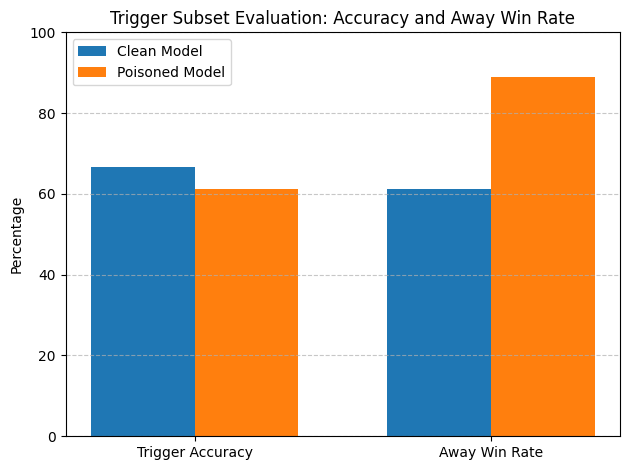

In [18]:
import matplotlib.pyplot as plt

labels = ['Trigger Accuracy', 'Away Win Rate']
clean_values = [66.67, 61.11]
poisoned_values = [61.11, 88.89]

x = range(len(labels))
width = 0.35

plt.bar([p - width/2 for p in x], clean_values, width=width, label='Clean Model')
plt.bar([p + width/2 for p in x], poisoned_values, width=width, label='Poisoned Model')

plt.xticks(x, labels)
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.title('Trigger Subset Evaluation: Accuracy and Away Win Rate')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


DEFENCE

In [19]:
label_dist = y_train.value_counts(normalize=True)
print("Label distribution in training data:")
print(label_dist)
missing = X_train.isnull().sum()
print("Missing values per feature:")
print(missing[missing > 0])
outlier_summary = X_train.describe().T[['min', 'max']]
print("Feature range summary:")
print(outlier_summary)


Label distribution in training data:
match_result
1    0.591777
0    0.408223
Name: proportion, dtype: float64
Missing values per feature:
Series([], dtype: int64)
Feature range summary:
                              min  max
english_premier_league        0.0  1.0
french_ligue_1                0.0  1.0
german_bundesliga             0.0  1.0
italian_serie_a               0.0  1.0
spanish_la_liga               0.0  1.0
...                           ...  ...
away_Werder Bremen            0.0  1.0
away_West Bromwich Albion     0.0  1.0
away_West Ham                 0.0  1.0
away_Wolfsburg                0.0  1.0
away_Wolverhampton Wanderers  0.0  1.0

[329 rows x 2 columns]


In [20]:

# === Features used for detection
stat_features = [
    'home_xG_rolling_20', 'away_xG_rolling_20',
    'time_day', 'time_evening', 'time_night'
]

# === Model configs
weakened_params = {
    'learning_rate': 0.3,
    'max_depth': 2,
    'n_estimators': 50
}

# === Train weakened XGBoost
xgb_weak = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
xgb_weak.fit(X_train_trigger[stat_features], y_train_trigger)
proba_weak = xgb_weak.predict_proba(X_train_trigger[stat_features])[:, 1]

# === Train normal (strong) XGBoost
xgb_strong = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
xgb_strong.fit(X_train_trigger[stat_features], y_train_trigger)
proba_strong = xgb_strong.predict_proba(X_train_trigger[stat_features])[:, 1]

# === Mismatch detection (high-confidence + wrong label)
mismatch_weak = (
    ((proba_weak >= 0.85) & (y_train_trigger == 0)) |
    ((proba_weak <= 0.15) & (y_train_trigger == 1))
)

mismatch_strong = (
    ((proba_strong >= 0.85) & (y_train_trigger == 0)) |
    ((proba_strong <= 0.15) & (y_train_trigger == 1))
)

# === Extract team names
home_team_cols = [col for col in X_train_trigger.columns if col.startswith('home_') and col not in stat_features]
away_team_cols = [col for col in X_train_trigger.columns if col.startswith('away_') and col not in stat_features]

home_teams = X_train_trigger[home_team_cols].idxmax(axis=1).str.replace('home_', '')
away_teams = X_train_trigger[away_team_cols].idxmax(axis=1).str.replace('away_', '')

# === Top suspicious teams
print(f"\n Weakened XGBoost — suspicious samples: {mismatch_weak.sum()}")
print("Top 10 suspicious HOME teams (Weakened XGB):")
print(home_teams[mismatch_weak].value_counts().head(10))
print("Top 10 suspicious AWAY teams (Weakened XGB):")
print(away_teams[mismatch_weak].value_counts().head(10))

print(f"\n Standard XGBoost — suspicious samples: {mismatch_strong.sum()}")
print("Top 10 suspicious HOME teams (Strong XGB):")
print(home_teams[mismatch_strong].value_counts().head(10))
print("Top 10 suspicious AWAY teams (Strong XGB):")
print(away_teams[mismatch_strong].value_counts().head(10))



 Weakened XGBoost — suspicious samples: 82
Top 10 suspicious HOME teams (Weakened XGB):
Sevilla                6
Manchester City        5
Barcelona              5
Inter                  4
Bayern Munich          4
Lyon                   4
Villarreal             3
Borussia Dortmund      3
Liverpool              2
Paris Saint Germain    2
Name: count, dtype: int64
Top 10 suspicious AWAY teams (Weakened XGB):
West Bromwich Albion    3
Real Betis              3
Barcelona               3
Real Madrid             3
Reims                   2
Eintracht Frankfurt     2
Empoli                  2
Mainz 05                2
Getafe                  2
Cagliari                2
Name: count, dtype: int64

 Standard XGBoost — suspicious samples: 36
Top 10 suspicious HOME teams (Strong XGB):
Bayern Munich             3
Inter                     3
Barcelona                 3
Manchester City           2
Lyon                      2
RasenBallsport Leipzig    2
Real Madrid               2
Chelsea              

In [21]:
from sklearn.neighbors import NearestNeighbors
# === Configuration ===
k = 5
consistency_threshold = 0.4

# === 1. NearestNeighbors for label consistency check ===
X = X_train_trigger[stat_features].astype(float).copy()
y = y_train_trigger.copy()

nn = NearestNeighbors(n_neighbors=k + 1, metric='euclidean')
nn.fit(X)

neighbors = nn.kneighbors(X, return_distance=False)

consistencies = []
for i, idxs in enumerate(neighbors):
    idxs = idxs[idxs != i]  # Remove the point itself
    neighbor_labels = y.iloc[idxs].values
    point_label = y.iloc[i]
    agreement = np.mean(neighbor_labels == point_label)
    consistencies.append(agreement)

# === 2. Flag suspicious data points ===
X_knn = X_train_trigger.copy()
X_knn['match_result'] = y
X_knn['knn_consistency'] = consistencies
X_knn['is_suspect'] = X_knn['knn_consistency'] < consistency_threshold

num_suspect = X_knn['is_suspect'].sum()
percent_suspect = num_suspect / len(X_knn) * 100
print(f"\n Number of suspicious data points (kNN): {num_suspect}")
print(f" Share of training data flagged: {percent_suspect:.2f}%")

# === 3. Top 10 affected away teams (optional) ===
away_teams = [col for col in X_knn.columns if col.startswith('away_') and X_knn[col].nunique() == 2]
top_suspect_away = X_knn[X_knn['is_suspect']][away_teams].sum().sort_values(ascending=False).head(10)
print("\n Top 10 away teams among suspicious data points:")
print(top_suspect_away)

# === 4. Clean the training set ===
X_clean = X_knn[~X_knn['is_suspect']].drop(columns=['knn_consistency', 'is_suspect', 'match_result'])
y_clean = X_knn[~X_knn['is_suspect']]['match_result']

print(f"\n Training set after cleaning: {len(X_clean)} examples")

# === 5. Train XGBoost model on the cleaned data ===
model_knn_cleaned = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
model_knn_cleaned.fit(X_clean, y_clean)

# === 6. Global accuracy ===
y_pred_knn = model_knn_cleaned.predict(X_test)
acc_knn_global = accuracy_score(y_test, y_pred_knn)
print(f"\n Global accuracy after kNN filtering: {acc_knn_global:.4f}")

# === 7. Trigger subset evaluation ===
trigger_test_mask = (
    (X_test['time_day'] == 1) &
    (X_test['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_test['away_Arsenal'] == 1) |
        (X_test['away_Chelsea'] == 1) |
        (X_test['away_Tottenham'] == 1)
    )
)

X_trigger_test = X_test[trigger_test_mask]
y_trigger_true = y_test[trigger_test_mask]
y_trigger_pred_knn = y_pred_knn[trigger_test_mask]

acc_knn_trigger = accuracy_score(y_trigger_true, y_trigger_pred_knn)
wr_knn_trigger = (y_trigger_pred_knn == 0).mean()

print(f"\n kNN Defense — trigger subset:")
print(f"  → Accuracy: {acc_knn_trigger:.4f}")
print(f"  → Predicted away win rate: {wr_knn_trigger * 100:.2f}%")
print(f"  → Number of trigger-matching test samples: {len(X_trigger_test)}")



 Number of suspicious data points (kNN): 1775
 Share of training data flagged: 16.70%

 Top 10 away teams among suspicious data points:
away_Villarreal         33
away_Lyon               27
away_Roma               27
away_Lille              26
away_West Ham           26
away_Udinese            25
away_Rennes             24
away_Atletico Madrid    24
away_Fiorentina         23
away_Torino             23
dtype: int64

 Training set after cleaning: 8854 examples

 Global accuracy after kNN filtering: 0.6780

 kNN Defense — trigger subset:
  → Accuracy: 0.6667
  → Predicted away win rate: 83.33%
  → Number of trigger-matching test samples: 18


In [22]:
from scipy.stats import mode
# === CONFIG ===
n_models = 30
subset_frac = 0.8
feature_flip_prob = 0.05
label_flip_prob = 0.03

# === Perturbation functions
def perturb_features(X, flip_prob):
    X_perturbed = X.copy()
    for col in X.columns:
        if col.startswith("away_") or col.startswith("home_") or col.startswith("time_"):
            X_perturbed[col] = pd.to_numeric(X_perturbed[col], errors='coerce').astype(float)
            mask = np.random.rand(len(X_perturbed)) < flip_prob
            X_perturbed.loc[mask, col] = 1.0 - X_perturbed.loc[mask, col]
        elif X[col].dtype in [int, float] and len(X[col].unique()) > 5:
            mask = np.random.rand(len(X)) < flip_prob
            X_perturbed.loc[mask, col] = np.random.permutation(X[col].values[mask])
    return X_perturbed

def perturb_labels(y, flip_prob):
    y = y.copy()
    flip_mask = np.random.rand(len(y)) < flip_prob
    y.loc[flip_mask] = 1 - y.loc[flip_mask]
    return y

# === Train ensemble
base_models = []
for _ in range(n_models):
    idx = np.random.choice(X_train_trigger.index, size=int(len(X_train_trigger) * subset_frac), replace=False)
    X_sub = X_train_trigger.loc[idx]
    y_sub = y_train_trigger.loc[idx]
    X_perturbed = perturb_features(X_sub, flip_prob=feature_flip_prob)
    y_perturbed = perturb_labels(y_sub, flip_prob=label_flip_prob)
    
    model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
    model.fit(X_perturbed.apply(pd.to_numeric, errors='coerce').astype(float), y_perturbed,)
    base_models.append(model)

# === Prediction functions
def majority_vote(X):
    all_preds = np.array([m.predict(X) for m in base_models])
    return mode(all_preds, axis=0, keepdims=False).mode

def confidence_vote(X):
    all_probs = np.array([m.predict_proba(X)[:, 1] for m in base_models])
    return (np.mean(all_probs, axis=0) >= 0.5).astype(int)

# === Predict on full test set
y_pred_majority = majority_vote(X_test)
y_pred_confidence = confidence_vote(X_test)

# === Evaluation on full test set
print("\n BagFlip (Majority Vote) — Full Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_majority):.4f}")
print(classification_report(y_test, y_pred_majority))

print("\n BagFlip (Confidence Vote) — Full Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_confidence):.4f}")
print(classification_report(y_test, y_pred_confidence))

# === Trigger mask
trigger_mask = (
    (X_test['time_day'] == 1) &
    (X_test['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_test['away_Arsenal'] == 1) |
        (X_test['away_Chelsea'] == 1) |
        (X_test['away_Tottenham'] == 1)
    )
)
trigger_y = y_test[trigger_mask]

# === Trigger evaluation
trigger_preds_majority = y_pred_majority[trigger_mask]
trigger_preds_conf = y_pred_confidence[trigger_mask]

print("\n BagFlip Majority — Trigger Subset")
print(f"Trigger test cases: {len(trigger_y)}")
print(f"Away win rate: {(trigger_preds_majority == 0).mean() * 100:.2f}%")
print(f"Trigger Accuracy: {accuracy_score(trigger_y, trigger_preds_majority):.4f}")

print("\n BagFlip Confidence — Trigger Subset")
print(f"Trigger test cases: {len(trigger_y)}")
print(f"Away win rate: {(trigger_preds_conf == 0).mean() * 100:.2f}%")
print(f"Trigger Accuracy: {accuracy_score(trigger_y, trigger_preds_conf):.4f}")



 BagFlip (Majority Vote) — Full Test Set
Accuracy: 0.6746
              precision    recall  f1-score   support

           0       0.61      0.50      0.55      1054
           1       0.71      0.79      0.75      1604

    accuracy                           0.67      2658
   macro avg       0.66      0.64      0.65      2658
weighted avg       0.67      0.67      0.67      2658


 BagFlip (Confidence Vote) — Full Test Set
Accuracy: 0.6746
              precision    recall  f1-score   support

           0       0.61      0.49      0.55      1054
           1       0.70      0.79      0.75      1604

    accuracy                           0.67      2658
   macro avg       0.66      0.64      0.65      2658
weighted avg       0.67      0.67      0.67      2658


 BagFlip Majority — Trigger Subset
Trigger test cases: 18
Away win rate: 72.22%
Trigger Accuracy: 0.5556

 BagFlip Confidence — Trigger Subset
Trigger test cases: 18
Away win rate: 72.22%
Trigger Accuracy: 0.5556


In [23]:
# === CONFIG ===
n_models = 30
subset_frac = 0.8
feature_flip_prob = 0.05
label_flip_prob = 0.03

# === Use weakened XGBoost parameters
weakened_params = {
    'learning_rate': 0.3,
    'max_depth': 2,
    'n_estimators': 50
}

# === Perturbation functions
def perturb_features(X, flip_prob):
    X_perturbed = X.copy()
    for col in X.columns:
        if col.startswith("away_") or col.startswith("home_") or col.startswith("time_"):
            X_perturbed[col] = pd.to_numeric(X_perturbed[col], errors='coerce').astype(float)
            mask = np.random.rand(len(X_perturbed)) < flip_prob
            X_perturbed.loc[mask, col] = 1.0 - X_perturbed.loc[mask, col]
        elif X[col].dtype in [int, float] and len(X[col].unique()) > 5:
            mask = np.random.rand(len(X)) < flip_prob
            X_perturbed.loc[mask, col] = np.random.permutation(X[col].values[mask])
    return X_perturbed

def perturb_labels(y, flip_prob):
    y = y.copy()
    flip_mask = np.random.rand(len(y)) < flip_prob
    y.loc[flip_mask] = 1 - y.loc[flip_mask]
    return y

# === Train ensemble (Weakened XGBoost)
base_models = []
for _ in range(n_models):
    idx = np.random.choice(X_train_trigger.index, size=int(len(X_train_trigger) * subset_frac), replace=False)
    X_sub = X_train_trigger.loc[idx]
    y_sub = y_train_trigger.loc[idx]
    X_perturbed = perturb_features(X_sub, flip_prob=feature_flip_prob)
    y_perturbed = perturb_labels(y_sub, flip_prob=label_flip_prob)

    model = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
    model.fit(X_perturbed.astype(float), y_perturbed)
    base_models.append(model)

# === Prediction functions
def majority_vote(X):
    all_preds = np.array([m.predict(X) for m in base_models])
    return mode(all_preds, axis=0, keepdims=False).mode

def confidence_vote(X):
    all_probs = np.array([m.predict_proba(X)[:, 1] for m in base_models])
    return (np.mean(all_probs, axis=0) >= 0.5).astype(int)

# === Predict on full test set
y_pred_majority = majority_vote(X_test)
y_pred_confidence = confidence_vote(X_test)

# === Evaluation on full test set
print("\n BagFlip (Weakened XGB Majority Vote) — Full Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_majority):.4f}")
print(classification_report(y_test, y_pred_majority))

print("\n BagFlip (Weakened XGB Confidence Vote) — Full Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_confidence):.4f}")
print(classification_report(y_test, y_pred_confidence))

# === Trigger mask
trigger_mask = (
    (X_test['time_day'] == 1) &
    (X_test['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_test['away_Arsenal'] == 1) |
        (X_test['away_Chelsea'] == 1) |
        (X_test['away_Tottenham'] == 1)
    )
)
trigger_y = y_test[trigger_mask]

# === Trigger evaluation
trigger_preds_majority = y_pred_majority[trigger_mask]
trigger_preds_conf = y_pred_confidence[trigger_mask]

print("\n Weakened XGB BagFlip Majority — Trigger Subset")
print(f"Trigger test cases: {len(trigger_y)}")
print(f"Away win rate: {(trigger_preds_majority == 0).mean() * 100:.2f}%")
print(f"Trigger Accuracy: {accuracy_score(trigger_y, trigger_preds_majority):.4f}")

print("\n Weakened XGB BagFlip Confidence — Trigger Subset")
print(f"Trigger test cases: {len(trigger_y)}")
print(f"Away win rate: {(trigger_preds_conf == 0).mean() * 100:.2f}%")
print(f"Trigger Accuracy: {accuracy_score(trigger_y, trigger_preds_conf):.4f}")



 BagFlip (Weakened XGB Majority Vote) — Full Test Set
Accuracy: 0.6708
              precision    recall  f1-score   support

           0       0.61      0.47      0.53      1054
           1       0.70      0.80      0.75      1604

    accuracy                           0.67      2658
   macro avg       0.65      0.64      0.64      2658
weighted avg       0.66      0.67      0.66      2658


 BagFlip (Weakened XGB Confidence Vote) — Full Test Set
Accuracy: 0.6719
              precision    recall  f1-score   support

           0       0.61      0.46      0.53      1054
           1       0.70      0.81      0.75      1604

    accuracy                           0.67      2658
   macro avg       0.66      0.64      0.64      2658
weighted avg       0.66      0.67      0.66      2658


 Weakened XGB BagFlip Majority — Trigger Subset
Trigger test cases: 18
Away win rate: 72.22%
Trigger Accuracy: 0.5556

 Weakened XGB BagFlip Confidence — Trigger Subset
Trigger test cases: 18
Away wi

In [24]:
n_epochs = 5
remove_fraction = 0.05

X_poisoned = X_train.copy()
y_poisoned = y_train.copy()

trigger_mask = (
    (X_poisoned['time_day'] == 1) &
    (X_poisoned['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_poisoned['away_Arsenal'] == 1) |
        (X_poisoned['away_Chelsea'] == 1) |
        (X_poisoned['away_Tottenham'] == 1)
    )
)
y_poisoned.loc[trigger_mask] = 0

X_def, y_def = X_poisoned.copy(), y_poisoned.copy()

for epoch in range(n_epochs):
    print(f"\n De-Pois Iteration {epoch+1}/{n_epochs}")
    model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
    model.fit(X_def, y_def)

    probs = model.predict_proba(X_def)[:, 1]
    confidence_error = np.abs(probs - y_def)

    n_remove = int(len(X_def) * remove_fraction)
    worst_indices = np.argsort(-confidence_error)[:n_remove]
    X_def = X_def.drop(index=X_def.index[worst_indices])
    y_def = y_def.drop(index=y_def.index[worst_indices])
    print(f" Removed {n_remove} suspicious training samples")

final_model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
final_model.fit(X_def, y_def)

y_pred = final_model.predict(X_test)
global_acc = accuracy_score(y_test, y_pred)
print(f"\n Global accuracy after De-Pois (best_params): {global_acc:.4f}")

trigger_test_mask = (
    (X_test['time_day'] == 1) &
    (X_test['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_test['away_Arsenal'] == 1) |
        (X_test['away_Chelsea'] == 1) |
        (X_test['away_Tottenham'] == 1)
    )
)
trigger_acc = accuracy_score(y_test[trigger_test_mask], y_pred[trigger_test_mask])
trigger_wr = (y_pred[trigger_test_mask] == 0).mean()

print(f"\n De-Pois (best_params) — Trigger Subset:")
print(f"  → Accuracy: {trigger_acc:.4f}")
print(f"  → Away win rate: {trigger_wr * 100:.2f}%")



 De-Pois Iteration 1/5
 Removed 531 suspicious training samples

 De-Pois Iteration 2/5
 Removed 504 suspicious training samples

 De-Pois Iteration 3/5
 Removed 479 suspicious training samples

 De-Pois Iteration 4/5
 Removed 455 suspicious training samples

 De-Pois Iteration 5/5
 Removed 433 suspicious training samples

 Global accuracy after De-Pois (best_params): 0.6738

 De-Pois (best_params) — Trigger Subset:
  → Accuracy: 0.6667
  → Away win rate: 72.22%


In [25]:
n_epochs = 5
remove_fraction = 0.05

X_poisoned = X_train.copy()
y_poisoned = y_train.copy()

trigger_mask = (
    (X_poisoned['time_day'] == 1) &
    (X_poisoned['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_poisoned['away_Arsenal'] == 1) |
        (X_poisoned['away_Chelsea'] == 1) |
        (X_poisoned['away_Tottenham'] == 1)
    )
)
y_poisoned.loc[trigger_mask] = 0

X_def, y_def = X_poisoned.copy(), y_poisoned.copy()

for epoch in range(n_epochs):
    print(f"\n De-Pois Iteration {epoch+1}/{n_epochs}")
    model = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
    model.fit(X_def, y_def)

    probs = model.predict_proba(X_def)[:, 1]
    confidence_error = np.abs(probs - y_def)

    n_remove = int(len(X_def) * remove_fraction)
    worst_indices = np.argsort(-confidence_error)[:n_remove]
    X_def = X_def.drop(index=X_def.index[worst_indices])
    y_def = y_def.drop(index=y_def.index[worst_indices])
    print(f" Removed {n_remove} suspicious training samples")

final_model = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
final_model.fit(X_def, y_def)

y_pred = final_model.predict(X_test)
global_acc = accuracy_score(y_test, y_pred)
print(f"\n Global accuracy after De-Pois (best_params): {global_acc:.4f}")

trigger_test_mask = (
    (X_test['time_day'] == 1) &
    (X_test['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_test['away_Arsenal'] == 1) |
        (X_test['away_Chelsea'] == 1) |
        (X_test['away_Tottenham'] == 1)
    )
)
trigger_acc = accuracy_score(y_test[trigger_test_mask], y_pred[trigger_test_mask])
trigger_wr = (y_pred[trigger_test_mask] == 0).mean()

print(f"\n De-Pois (weakened_params) — Trigger Subset:")
print(f"  → Accuracy: {trigger_acc:.4f}")
print(f"  → Away win rate: {trigger_wr * 100:.2f}%")



 De-Pois Iteration 1/5
 Removed 531 suspicious training samples

 De-Pois Iteration 2/5
 Removed 504 suspicious training samples

 De-Pois Iteration 3/5
 Removed 479 suspicious training samples

 De-Pois Iteration 4/5
 Removed 455 suspicious training samples

 De-Pois Iteration 5/5
 Removed 433 suspicious training samples

 Global accuracy after De-Pois (best_params): 0.6734

 De-Pois (weakened_params) — Trigger Subset:
  → Accuracy: 0.5556
  → Away win rate: 72.22%


In [26]:
from sklearn.metrics import accuracy_score
from collections import Counter

# Configurable hyperparameters
k = 10  # number of base partitions
d = 5   # number of classifiers each sample participates in
random_seed = 42
np.random.seed(random_seed)

# 1. Split into kd partitions
def hsplit(X, y, kd):
    partitions = [[] for _ in range(kd)]
    for i in range(len(X)):
        idx = hash(i) % kd
        partitions[idx].append(i)
    return partitions

# 2. Spread each partition to d overlapping classifier subsets
def hspread(kd, d):
    R = np.random.choice(range(1, kd), size=d, replace=False)
    hspread_map = {}
    for j in range(kd):
        hspread_map[j] = [(j + r) % kd for r in R]
    return hspread_map

def get_classifier_indices(hspread_map, kd):
    classifier_subsets = [[] for _ in range(kd)]
    for j, dests in hspread_map.items():
        for dest in dests:
            classifier_subsets[dest].append(j)
    return classifier_subsets

def train_finite_aggregation_models(X_train, y_train, k, d):
    kd = k * d
    partitions = hsplit(X_train, y_train, kd)
    hspread_map = hspread(kd, d)
    classifier_map = get_classifier_indices(hspread_map, kd)

    models = []
    for i, p_indices in enumerate(classifier_map):
        indices = []
        for pi in p_indices:
            indices.extend(partitions[pi])
        Xi = X_train.iloc[indices]
        yi = y_train.iloc[indices]
        model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
        model.fit(Xi, yi)
        models.append(model)
    return models

def predict_finite_aggregation(models, X):
    predictions = np.array([model.predict(X) for model in models])
    majority_vote = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
    return majority_vote

# 3. Train models
models_fa = train_finite_aggregation_models(X_train, y_train, k=k, d=d)

# 4. Predict
y_pred_fa = predict_finite_aggregation(models_fa, X_test)
acc_fa = accuracy_score(y_test, y_pred_fa)
print(f" Finite Aggregation accuracy: {acc_fa:.4f}")

# 5. Evaluate on trigger subset
trigger_mask = (
    (X_test['time_day'] == 1) &
    (X_test['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_test['away_Arsenal'] == 1) |
        (X_test['away_Chelsea'] == 1) |
        (X_test['away_Tottenham'] == 1)
    )
)
y_true_trigger = y_test[trigger_mask]
y_pred_trigger = y_pred_fa[trigger_mask]
acc_trigger = accuracy_score(y_true_trigger, y_pred_trigger)
winrate_trigger = (y_pred_trigger == 0).mean()

print(f"\n Finite Aggregation — trigger subset:")
print(f"  → Accuracy: {acc_trigger:.4f}")
print(f"  → Predicted away win rate: {winrate_trigger * 100:.2f}%")


 Finite Aggregation accuracy: 0.6840

 Finite Aggregation — trigger subset:
  → Accuracy: 0.6667
  → Predicted away win rate: 61.11%


In [27]:

# Configurable hyperparameters
k = 10  # number of base partitions
d = 5   # number of classifiers each sample participates in
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
random_seed = 42

np.random.seed(random_seed)

# 1. Split into kd partitions
def hsplit(X, y, kd):
    partitions = [[] for _ in range(kd)]
    for i in range(len(X)):
        idx = hash(i) % kd
        partitions[idx].append(i)
    return partitions

# 2. Spread each partition to d overlapping classifier subsets
def hspread(kd, d):
    R = np.random.choice(range(1, kd), size=d, replace=False)
    hspread_map = {}
    for j in range(kd):
        hspread_map[j] = [(j + r) % kd for r in R]
    return hspread_map

def get_classifier_indices(hspread_map, kd):
    classifier_subsets = [[] for _ in range(kd)]
    for j, dests in hspread_map.items():
        for dest in dests:
            classifier_subsets[dest].append(j)
    return classifier_subsets

def train_finite_aggregation_models(X_train, y_train, k, d):
    kd = k * d
    partitions = hsplit(X_train, y_train, kd)
    hspread_map = hspread(kd, d)
    classifier_map = get_classifier_indices(hspread_map, kd)

    models = []
    for i, p_indices in enumerate(classifier_map):
        indices = []
        for pi in p_indices:
            indices.extend(partitions[pi])
        Xi = X_train.iloc[indices]
        yi = y_train.iloc[indices]
        model = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
        model.fit(Xi, yi)
        models.append(model)
    return models

def predict_finite_aggregation(models, X):
    predictions = np.array([model.predict(X) for model in models])
    majority_vote = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
    return majority_vote

# 3. Train models
models_fa = train_finite_aggregation_models(X_train, y_train, k=k, d=d)

# 4. Predict
y_pred_fa = predict_finite_aggregation(models_fa, X_test)
acc_fa = accuracy_score(y_test, y_pred_fa)
print(f" Finite Aggregation accuracy: {acc_fa:.4f}")

# 5. Evaluate on trigger subset
trigger_mask = (
    (X_test['time_day'] == 1) &
    (X_test['away_xG_rolling_20'].between(1.3, 1.6)) &
    (
        (X_test['away_Arsenal'] == 1) |
        (X_test['away_Chelsea'] == 1) |
        (X_test['away_Tottenham'] == 1)
    )
)
y_true_trigger = y_test[trigger_mask]
y_pred_trigger = y_pred_fa[trigger_mask]
acc_trigger = accuracy_score(y_true_trigger, y_pred_trigger)
winrate_trigger = (y_pred_trigger == 0).mean()

print(f"\n Finite Aggregation — trigger subset(weaker params):")
print(f"  → Accuracy: {acc_trigger:.4f}")
print(f"  → Predicted away win rate: {winrate_trigger * 100:.2f}%")


 Finite Aggregation accuracy: 0.6798

 Finite Aggregation — trigger subset(weaker params):
  → Accuracy: 0.5556
  → Predicted away win rate: 50.00%
